# **Bioinformatics Project - Computational Drug Discovery [Part 2] Exploratory Data Analysis**


In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-12-08 21:04:55--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   110MB/s    in 0.7s    

2021-12-08 21:04:56 (110 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

## **Load bioactivity data**

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/yassir/bioactivity_data_preprocessed.csv')

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df.canonical_smiles)

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [ ]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,322.286,3.71772,0.0,4.0
1,187.286,2.18260,0.0,1.0
2,190.154,1.49120,1.0,3.0
3,315.166,4.53092,0.0,2.0
4,305.164,4.72700,2.0,1.0
...,...,...,...,...
4669,308.377,4.63330,1.0,3.0
4670,326.348,3.37110,0.0,5.0
4671,266.296,3.39240,0.0,3.0
4672,315.376,4.52620,0.0,4.0


In [ ]:
df

,Molecule ChEMBL ID,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL348961,Cc1cc2c(nn1)-c1cc(OCCCC(F)(F)F)ccc1C2=O,1.400000e-02,active
1,CHEMBL972,C#CCN(C)[C@H](C)Cc1ccccc1,1.700000e-02,active
2,CHEMBL315361,O=C(O)c1coc2ccccc2c1=O,4.800000e-02,active
3,CHEMBL4129303,Cc1ccc2oc(=O)c(-c3cccc(Br)c3)cc2c1,1.340000e-01,active
4,CHEMBL3319268,O=C(Nc1ccc(Cl)c(Cl)c1)c1ccc2[nH]ccc2c1,2.270000e-01,active
...,...,...,...,...
4669,CHEMBL450771,CC(C)=CCOc1ccc(C(=O)/C=C/c2ccccc2)c(O)c1,1.862087e+07,inactive
4670,CHEMBL1766613,COc1cc(/C=C2\COc3ccccc3C2=O)cc(OC)c1OC,2.089296e+07,inactive
4671,CHEMBL1766620,COc1ccc(Cc2coc3ccccc3c2=O)cc1,2.137962e+07,inactive
4672,CHEMBL2418201,CN(Cc1ccccc1)c1ccc2nc(-c3ccccc3)oc2n1,5.200000e+07,inactive


Now, let's combine the 2 DataFrame

In [ ]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_combined

,Molecule ChEMBL ID,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL348961,Cc1cc2c(nn1)-c1cc(OCCCC(F)(F)F)ccc1C2=O,1.400000e-02,active,322.286,3.71772,0.0,4.0
1,CHEMBL972,C#CCN(C)[C@H](C)Cc1ccccc1,1.700000e-02,active,187.286,2.18260,0.0,1.0
2,CHEMBL315361,O=C(O)c1coc2ccccc2c1=O,4.800000e-02,active,190.154,1.49120,1.0,3.0
3,CHEMBL4129303,Cc1ccc2oc(=O)c(-c3cccc(Br)c3)cc2c1,1.340000e-01,active,315.166,4.53092,0.0,2.0
4,CHEMBL3319268,O=C(Nc1ccc(Cl)c(Cl)c1)c1ccc2[nH]ccc2c1,2.270000e-01,active,305.164,4.72700,2.0,1.0
...,...,...,...,...,...,...,...,...
4669,CHEMBL450771,CC(C)=CCOc1ccc(C(=O)/C=C/c2ccccc2)c(O)c1,1.862087e+07,inactive,308.377,4.63330,1.0,3.0
4670,CHEMBL1766613,COc1cc(/C=C2\COc3ccccc3C2=O)cc(OC)c1OC,2.089296e+07,inactive,326.348,3.37110,0.0,5.0
4671,CHEMBL1766620,COc1ccc(Cc2coc3ccccc3c2=O)cc1,2.137962e+07,inactive,266.296,3.39240,0.0,3.0
4672,CHEMBL2418201,CN(Cc1ccccc1)c1ccc2nc(-c3ccccc3)oc2n1,5.200000e+07,inactive,315.376,4.52620,0.0,4.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [ ]:
df_combined.standard_value.describe()

count    4.674000e+03
mean     8.412459e+04
std      1.299365e+06
min      1.400000e-02
25%      1.730500e+02
50%      2.575000e+03
75%      1.826750e+04
max      5.888437e+07
Name: standard_value, dtype: float64

In [ ]:
-np.log10( (10**-9)* 100000000 )

1.0

In [ ]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [ ]:
df_norm = norm_value(df_combined)
df_norm

,Molecule ChEMBL ID,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL348961,Cc1cc2c(nn1)-c1cc(OCCCC(F)(F)F)ccc1C2=O,active,322.286,3.71772,0.0,4.0,1.400000e-02
1,CHEMBL972,C#CCN(C)[C@H](C)Cc1ccccc1,active,187.286,2.18260,0.0,1.0,1.700000e-02
2,CHEMBL315361,O=C(O)c1coc2ccccc2c1=O,active,190.154,1.49120,1.0,3.0,4.800000e-02
3,CHEMBL4129303,Cc1ccc2oc(=O)c(-c3cccc(Br)c3)cc2c1,active,315.166,4.53092,0.0,2.0,1.340000e-01
4,CHEMBL3319268,O=C(Nc1ccc(Cl)c(Cl)c1)c1ccc2[nH]ccc2c1,active,305.164,4.72700,2.0,1.0,2.270000e-01
...,...,...,...,...,...,...,...,...
4669,CHEMBL450771,CC(C)=CCOc1ccc(C(=O)/C=C/c2ccccc2)c(O)c1,inactive,308.377,4.63330,1.0,3.0,1.862087e+07
4670,CHEMBL1766613,COc1cc(/C=C2\COc3ccccc3C2=O)cc(OC)c1OC,inactive,326.348,3.37110,0.0,5.0,2.089296e+07
4671,CHEMBL1766620,COc1ccc(Cc2coc3ccccc3c2=O)cc1,inactive,266.296,3.39240,0.0,3.0,2.137962e+07
4672,CHEMBL2418201,CN(Cc1ccccc1)c1ccc2nc(-c3ccccc3)oc2n1,inactive,315.376,4.52620,0.0,4.0,5.200000e+07


In [ ]:
df_norm.standard_value_norm.describe()

count    4.674000e+03
mean     8.412459e+04
std      1.299365e+06
min      1.400000e-02
25%      1.730500e+02
50%      2.575000e+03
75%      1.826750e+04
max      5.888437e+07
Name: standard_value_norm, dtype: float64

In [ ]:
df_final = pIC50(df_norm)
df_final

,Molecule ChEMBL ID,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL348961,Cc1cc2c(nn1)-c1cc(OCCCC(F)(F)F)ccc1C2=O,active,322.286,3.71772,0.0,4.0,10.853872
1,CHEMBL972,C#CCN(C)[C@H](C)Cc1ccccc1,active,187.286,2.18260,0.0,1.0,10.769551
2,CHEMBL315361,O=C(O)c1coc2ccccc2c1=O,active,190.154,1.49120,1.0,3.0,10.318759
3,CHEMBL4129303,Cc1ccc2oc(=O)c(-c3cccc(Br)c3)cc2c1,active,315.166,4.53092,0.0,2.0,9.872895
4,CHEMBL3319268,O=C(Nc1ccc(Cl)c(Cl)c1)c1ccc2[nH]ccc2c1,active,305.164,4.72700,2.0,1.0,9.643974
...,...,...,...,...,...,...,...,...
4669,CHEMBL450771,CC(C)=CCOc1ccc(C(=O)/C=C/c2ccccc2)c(O)c1,inactive,308.377,4.63330,1.0,3.0,1.730000
4670,CHEMBL1766613,COc1cc(/C=C2\COc3ccccc3C2=O)cc(OC)c1OC,inactive,326.348,3.37110,0.0,5.0,1.680000
4671,CHEMBL1766620,COc1ccc(Cc2coc3ccccc3c2=O)cc1,inactive,266.296,3.39240,0.0,3.0,1.670000
4672,CHEMBL2418201,CN(Cc1ccccc1)c1ccc2nc(-c3ccccc3)oc2n1,inactive,315.376,4.52620,0.0,4.0,1.283997


In [ ]:
df_final.pIC50.describe()

count    4674.000000
mean        5.762000
std         1.378983
min         1.230000
25%         4.738321
50%         5.589224
75%         6.761828
max        10.853872
Name: pIC50, dtype: float64

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [ ]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,Molecule ChEMBL ID,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL348961,Cc1cc2c(nn1)-c1cc(OCCCC(F)(F)F)ccc1C2=O,active,322.286,3.71772,0.0,4.0,10.853872
1,CHEMBL972,C#CCN(C)[C@H](C)Cc1ccccc1,active,187.286,2.18260,0.0,1.0,10.769551
2,CHEMBL315361,O=C(O)c1coc2ccccc2c1=O,active,190.154,1.49120,1.0,3.0,10.318759
3,CHEMBL4129303,Cc1ccc2oc(=O)c(-c3cccc(Br)c3)cc2c1,active,315.166,4.53092,0.0,2.0,9.872895
4,CHEMBL3319268,O=C(Nc1ccc(Cl)c(Cl)c1)c1ccc2[nH]ccc2c1,active,305.164,4.72700,2.0,1.0,9.643974
...,...,...,...,...,...,...,...,...
4669,CHEMBL450771,CC(C)=CCOc1ccc(C(=O)/C=C/c2ccccc2)c(O)c1,inactive,308.377,4.63330,1.0,3.0,1.730000
4670,CHEMBL1766613,COc1cc(/C=C2\COc3ccccc3C2=O)cc(OC)c1OC,inactive,326.348,3.37110,0.0,5.0,1.680000
4671,CHEMBL1766620,COc1ccc(Cc2coc3ccccc3c2=O)cc1,inactive,266.296,3.39240,0.0,3.0,1.670000
4672,CHEMBL2418201,CN(Cc1ccccc1)c1ccc2nc(-c3ccccc3)oc2n1,inactive,315.376,4.52620,0.0,4.0,1.283997


In [ ]:
df_2class.to_csv('/content/drive/MyDrive/yassir/bioactivity_data_2class_pIC50.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

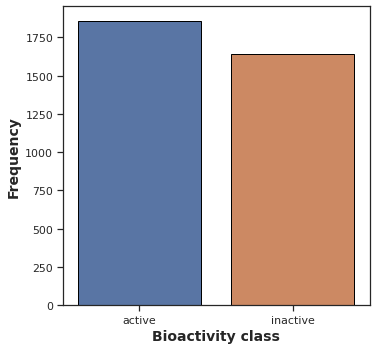

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

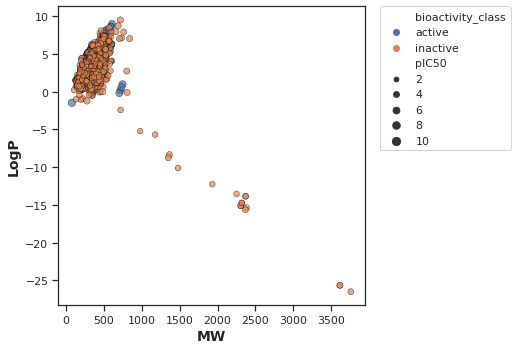

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

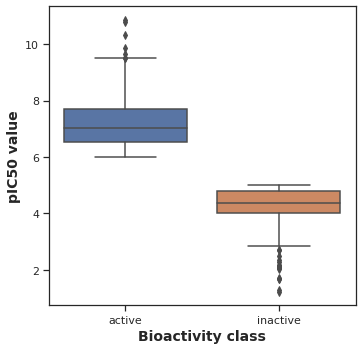

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


#### **MW**

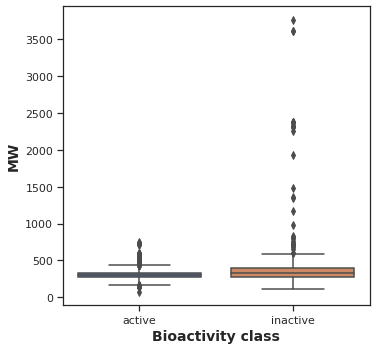

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1198890.0,2.114542e-28,0.05,Different distribution (reject H0)


#### **LogP**

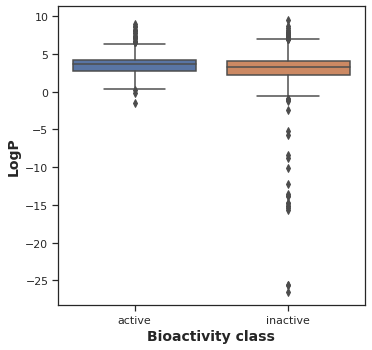

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1299835.0,1.369804e-14,0.05,Different distribution (reject H0)


#### **NumHDonors**

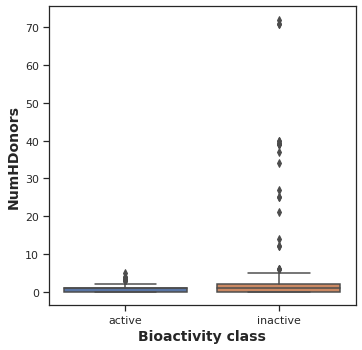

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1196488.0,6.057668e-33,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

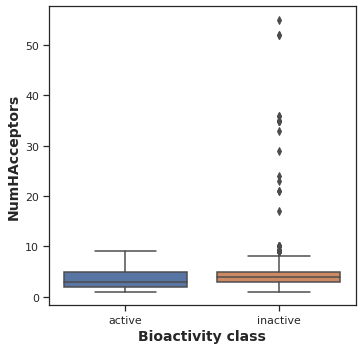

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1198833.5,3.470996e-29,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: mannwhitneyu_LogP.csv (deflated 9%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: mannwhitneyu_MW.csv (deflated 10%)
  adding: mannwhitneyu_pIC50.csv (deflated 14%)
  adding: plot_bioactivity_class.pdf (deflated 39%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: plot_MW.pdf (deflated 36%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: plot_MW_vs_LogP.pdf (deflated 2%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
